## Here I will do quality checks and prepare the input data for the final linkage map for R. temporaria. 


In [1]:
%matplotlib inline
from __future__ import division
import shutil
import os
import MISC_RAD_tools as MISC
import pprint
import subprocess
import numpy as np
import datetime
from matplotlib import pyplot as plt

In [3]:
### Function for plotting the missing data in a VCF

## Note that this function morphed into what is now Summary_plotter.

def Missing_data_plotter(input_vcf_path, switches = (1,1,1), sort = True):
    
    """
    input_vcf_path = full path to vcf
    switches = tuple of switches (0 or 1) for the missing data, coverage and heterozygosity plots in that order
    
    """
    
    from matplotlib import pyplot as plt
    from matplotlib import gridspec
    import numpy as np
    import operator
    
    
    
    input_vcf = open(input_vcf_path, 'r').readlines()
    
    samples_ordered = [] ## get samples in the order they are in the vcf
    
    per_sample_missing_data = {} ## record missing data per sample
    per_sample_coverage = {} ## record coverage per sample
    per_sample_heterozygosity = {} ## recordN heterozygous loci per sample
    
    per_locus_coverage = {} ## record the average coverage per locus across samples
    per_locus_heterozygosity = {}  ## record the proportion of heterozygous samples for each locus
    
    
    format_fields = ["#CHROM", "POS", "ID", "REF", "ALT", "QUAL", "FILTER", "INFO", "FORMAT"]
    
    N_loci = 0
    
    for line in input_vcf:
        
        if line.startswith("#CHROM"):
            for field in line.split():
                if field not in format_fields:
                    if field not in per_sample_missing_data:
                        per_sample_missing_data[field] = 0
                        per_sample_coverage[field] = []
                        per_sample_heterozygosity[field] = 0
                        
                        samples_ordered.append(field)
                        

        elif not line.startswith("#"):
            
            N_loci += 1
            
            record_ID = "%s_%s" % (line.split()[2], line.split()[1])
            
            NS = int(line.split()[7].split(";")[0].split("=")[1])
            
            record = line.split()[9:]
            
            N_samples_het = 0
            
            record_coverage_list = []
            
            sample_index = 0
            
            for sample_field in record:
                
                sample_name = samples_ordered[sample_index]
                                
                DP = sample_field.split(":")[1]
                
                per_sample_coverage[sample_name].append(int(DP))
                record_coverage_list.append(int(DP))
                
                
                GT = sample_field.split(":")[0]
                
                if GT == "1/0" or GT == "0/1":
                    
                    per_sample_heterozygosity[sample_name] += 1
                    
                    N_samples_het += 1                    
                
                elif GT == "./.":
                    per_sample_missing_data[sample_name] += 1
                    
                sample_index += 1
        
            per_locus_heterozygosity[record_ID] = N_samples_het/NS
            per_locus_coverage[record_ID] = np.mean(record_coverage_list)

    
    ### Get the means of the samples
    
    per_sample_coverage_means = {}
        
    for sample in per_sample_coverage:
        per_sample_coverage_means[sample] = np.mean(per_sample_coverage[sample])
    
    

    ####### Make plots ###############
    
    fig = plt.figure(figsize = (30,70))  

    
    if switches[0] == 1: ## make the missing data plot
        
        
        if sort == True:

            ## order the missing data

            missing_sorted_sample_names = [i[0] for i in sorted(per_sample_missing_data.items(), key=operator.itemgetter(1), reverse=True)]
    
        else:
            missing_sorted_sample_names = samples_ordered
        
         
        ## Plot figure
        
        #fig = plt.figure(figsize = (30,10))
        
        ax1 = plt.subplot2grid((4,2),(0,0),colspan=2) 
        
        #ax = fig.add_subplot(111)
        
        bar_pos = 1
        
        x_tick_pos = []
        x_tick_labs = []
        
        for sample in missing_sorted_sample_names:
            x_tick_labs.append(sample)
            x_tick_pos.append(bar_pos)
            ax1.bar(bar_pos, per_sample_missing_data[sample], color = "royalblue", align = "center")
            bar_pos += 1
        
        ax1.hlines(np.mean(per_sample_missing_data.values()), 0, len(per_sample_missing_data))
        
        plt.xticks(x_tick_pos, x_tick_labs, rotation = 90)
        plt.title("Missing data per sample")
        #plt.show()
        
    
    
    if switches[1] == 1: ## make the heterozygosity plot
                

        ## Plot figure
        
        #fig = plt.figure(figsize = (30,10))
        
        #ax = fig.add_subplot(111)
        
        ax2 = plt.subplot2grid((4,2),(1,0),colspan=2)
        
        bar_pos = 1
        
        x_tick_pos = []
        x_tick_labs = []
        
        prop_hets = {}
        
        ## First pass to calculate the heterozyousity as a proportion across all loci for each sample
        
        for sample in per_sample_heterozygosity:
            
            if per_sample_missing_data[sample] == 0:
                N_called = N_loci
            else:
                N_called = N_loci - per_sample_missing_data[sample]
            
            if N_called == 0:
                N_called = 1
            
            het_prop = per_sample_heterozygosity[sample]/N_called ## calculate proportion heterozygous
            
            prop_hets[sample] = het_prop
            
            
        if sort == True:

            ## order the missing data

            heterozygosity_sorted_sample_names = [i[0] for i in sorted(prop_hets.items(), key=operator.itemgetter(1), reverse=True)]  
        else:
            heterozygosity_sorted_sample_names = samples_ordered
            

        
        ## Second pass to plot
        
        for sample in heterozygosity_sorted_sample_names:    
            
            x_tick_labs.append(sample)
            x_tick_pos.append(bar_pos)
            
            ax2.bar(bar_pos, prop_hets[sample] , color = "orange", alpha = 0.7, align = "center")

            bar_pos += 1
        
        
        
        ax2.hlines(np.mean(prop_hets.values()), 0, len(per_sample_missing_data))
        
        plt.xticks(x_tick_pos, x_tick_labs, rotation = 90)
        plt.title("N heterozygous loci per sample")
        #plt.show()
    
    
    if switches[2] == 1: ## make the coverage plot
        
        
        overall_mean = np.mean(per_sample_coverage_means.values())
        
        
        if sort == True:

            ## order the missing data

            coverage_sorted_sample_names = [i[0] for i in sorted(per_sample_coverage_means.items(), key=operator.itemgetter(1), reverse=True)]  
        else:
            coverage_sorted_sample_names = samples_ordered
             
        
        
        #fig = plt.figure(figsize = (30,10))
        
        #ax = fig.add_subplot(111)
        
        ax3 = plt.subplot2grid((4,2),(2,0),colspan=2)
        
        
        vio_pos = 1
        
        x_tick_pos = []
        x_tick_labs = []
        
        for sample in coverage_sorted_sample_names:
            
            x_tick_pos.append(vio_pos)
            x_tick_labs.append(sample)
            
            if sum(per_sample_coverage[sample]) == 0:
                per_sample_coverage[sample].append(1)
                        
            
            vio = ax3.violinplot(per_sample_coverage[sample], positions = [vio_pos], showmeans=True,showextrema = False )
                        
            for pc in vio['bodies']:
                pc.set_facecolor('darkgreen')
                pc.set_edgecolor('black')
                pc.set_alpha(0.5)
                
            vio["cmeans"].set_color("black")
            
            vio_pos += 1
            
        plt.xticks(x_tick_pos, x_tick_labs, rotation = 90)
        plt.title("Locus coverage per sample")
    
            
    if switches[3] == 1: ## make the coverage vs Heterozygosity plots (per sample and per locus). Might take a little time for big datasets
        
        ## no sorting required here
        
        #fig = plt.figure(figsize = (30,15))
        
        #ax = fig.add_subplot(121)
        
        ax4 = plt.subplot2grid((4,2),(3,0))

        
        for sample in per_sample_coverage:
            
            if per_sample_missing_data[sample] == 0:
                N_called = N_loci
            else:
                N_called = N_loci - per_sample_missing_data[sample]
            
            if N_called == 0:
                N_called = 1
            
            ax4.scatter(per_sample_heterozygosity[sample]/N_called, per_sample_coverage_means[sample], color = "black")
            ax4.text((per_sample_heterozygosity[sample]/N_called)+0.002, per_sample_coverage_means[sample], sample[:10])
            
        plt.ylabel("Coverage (reads)")
        plt.xlabel("Prop. heterozygous loci")
        plt.title("Coverage Vs Heterozygosity")

        
        
        #ax1 = fig.add_subplot(122)
        
        ax5 = plt.subplot2grid((4,2),(3,1))
        
        for record in per_locus_coverage:
            
            ax5.scatter(per_locus_heterozygosity[record], per_locus_coverage[record], color = "black")
            
        plt.title("Per locus coverage vs heterozygosity")
        plt.xlabel("Prop. heterozygous samples")
        plt.ylabel("Mean coverage across samples")
        
    
    outfile = "%s_VCF_summary_stats.pdf" % vcf_path.rpartition(".")[0]
    
    plt.savefig(outfile)
    
    plt.show()
        
    print "#### DONE ####\n"
    
    print "Number of Loci = %s" %N_loci
    
    print "Average coverage = %s reads" % np.round(overall_mean, 2)
    
    
        
        

# SbfI families


### ST01

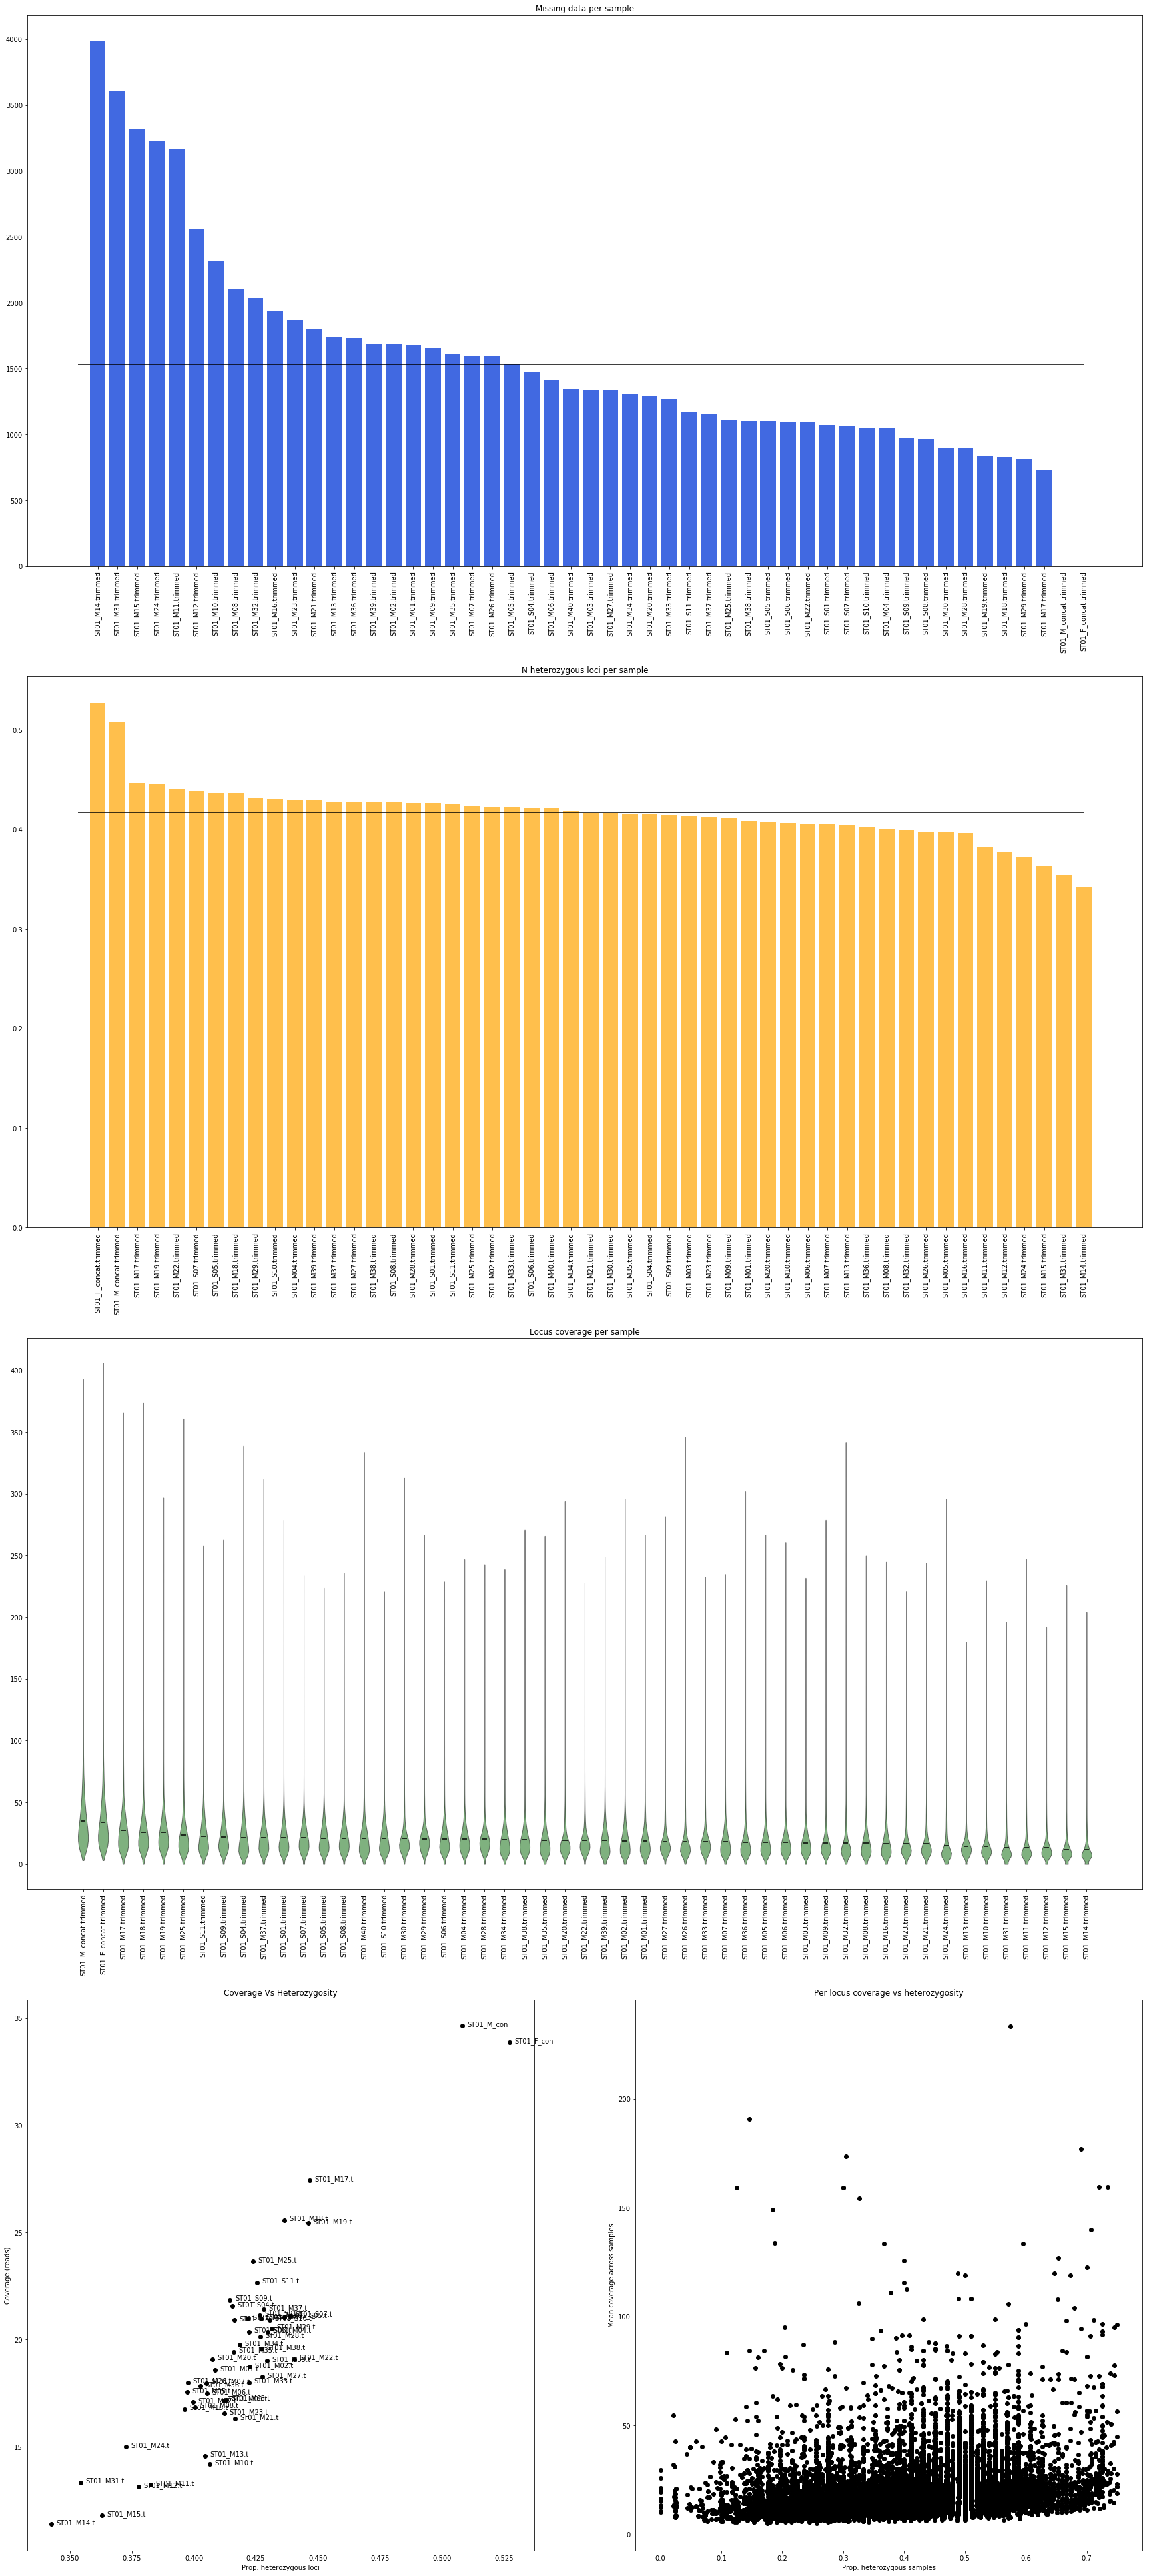

#### DONE ####

Number of Loci = 19632
Average coverage = 19.3940804928 reads


In [326]:
vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Final_linkage_map/Populations_ST01/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))

remove: ST01_M11, ST01_24, ST01_14, ST01_15, ST01_31, ST01_10, ST01_13, ST01_12

### ST16

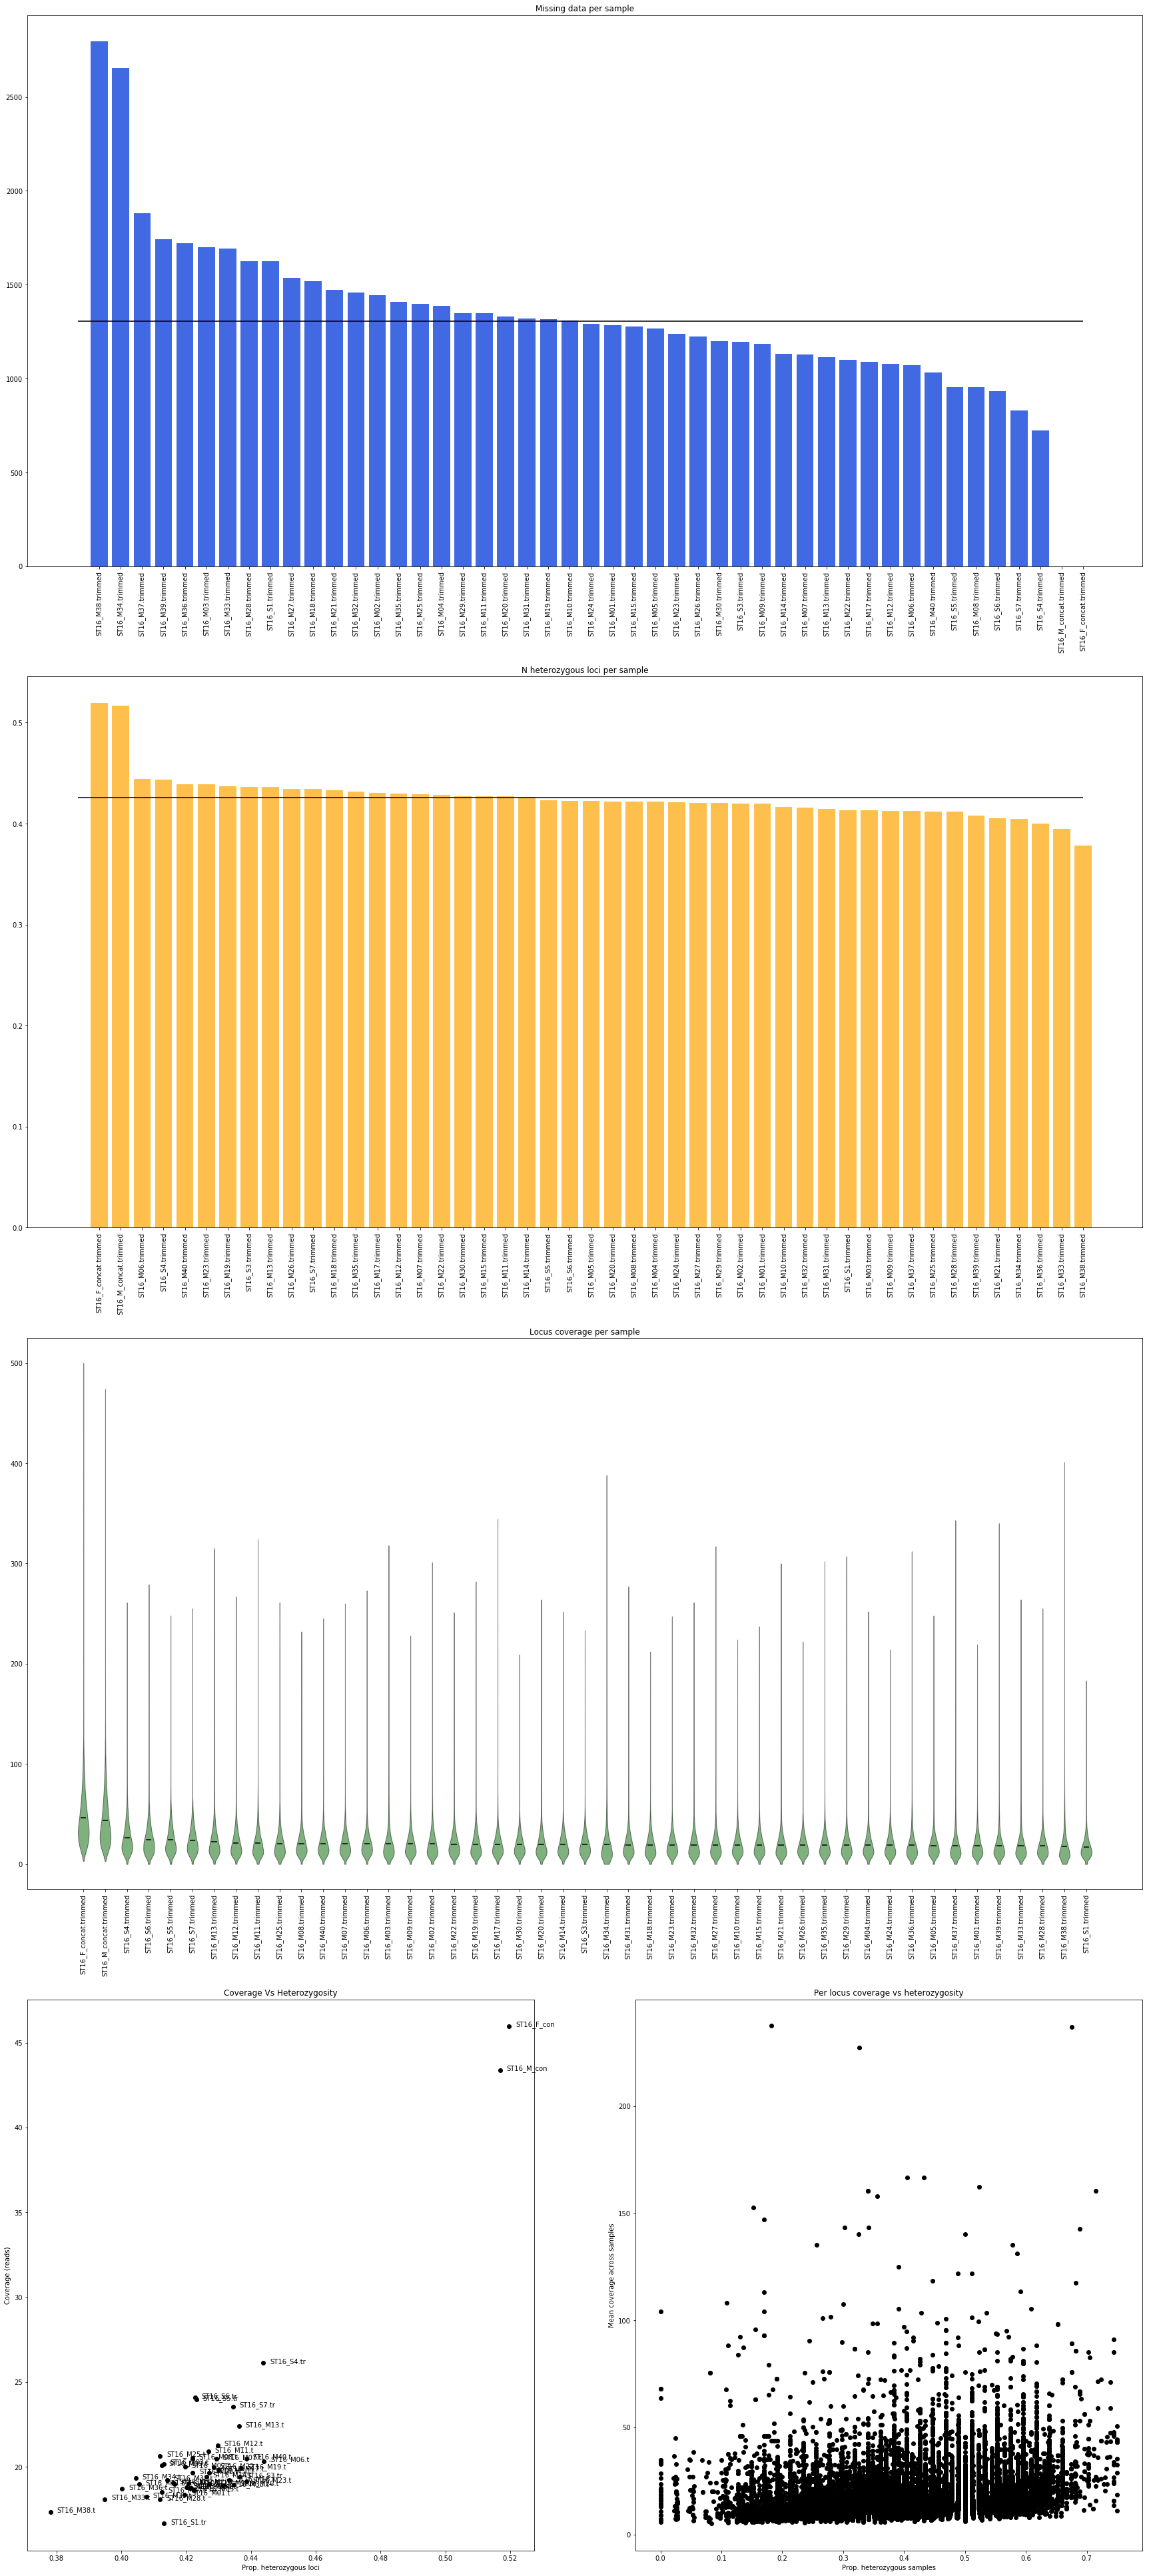

In [312]:
vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Final_linkage_map/Populations_ST16/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))

Remove: ST16_M38, ST16_M34

### ST18

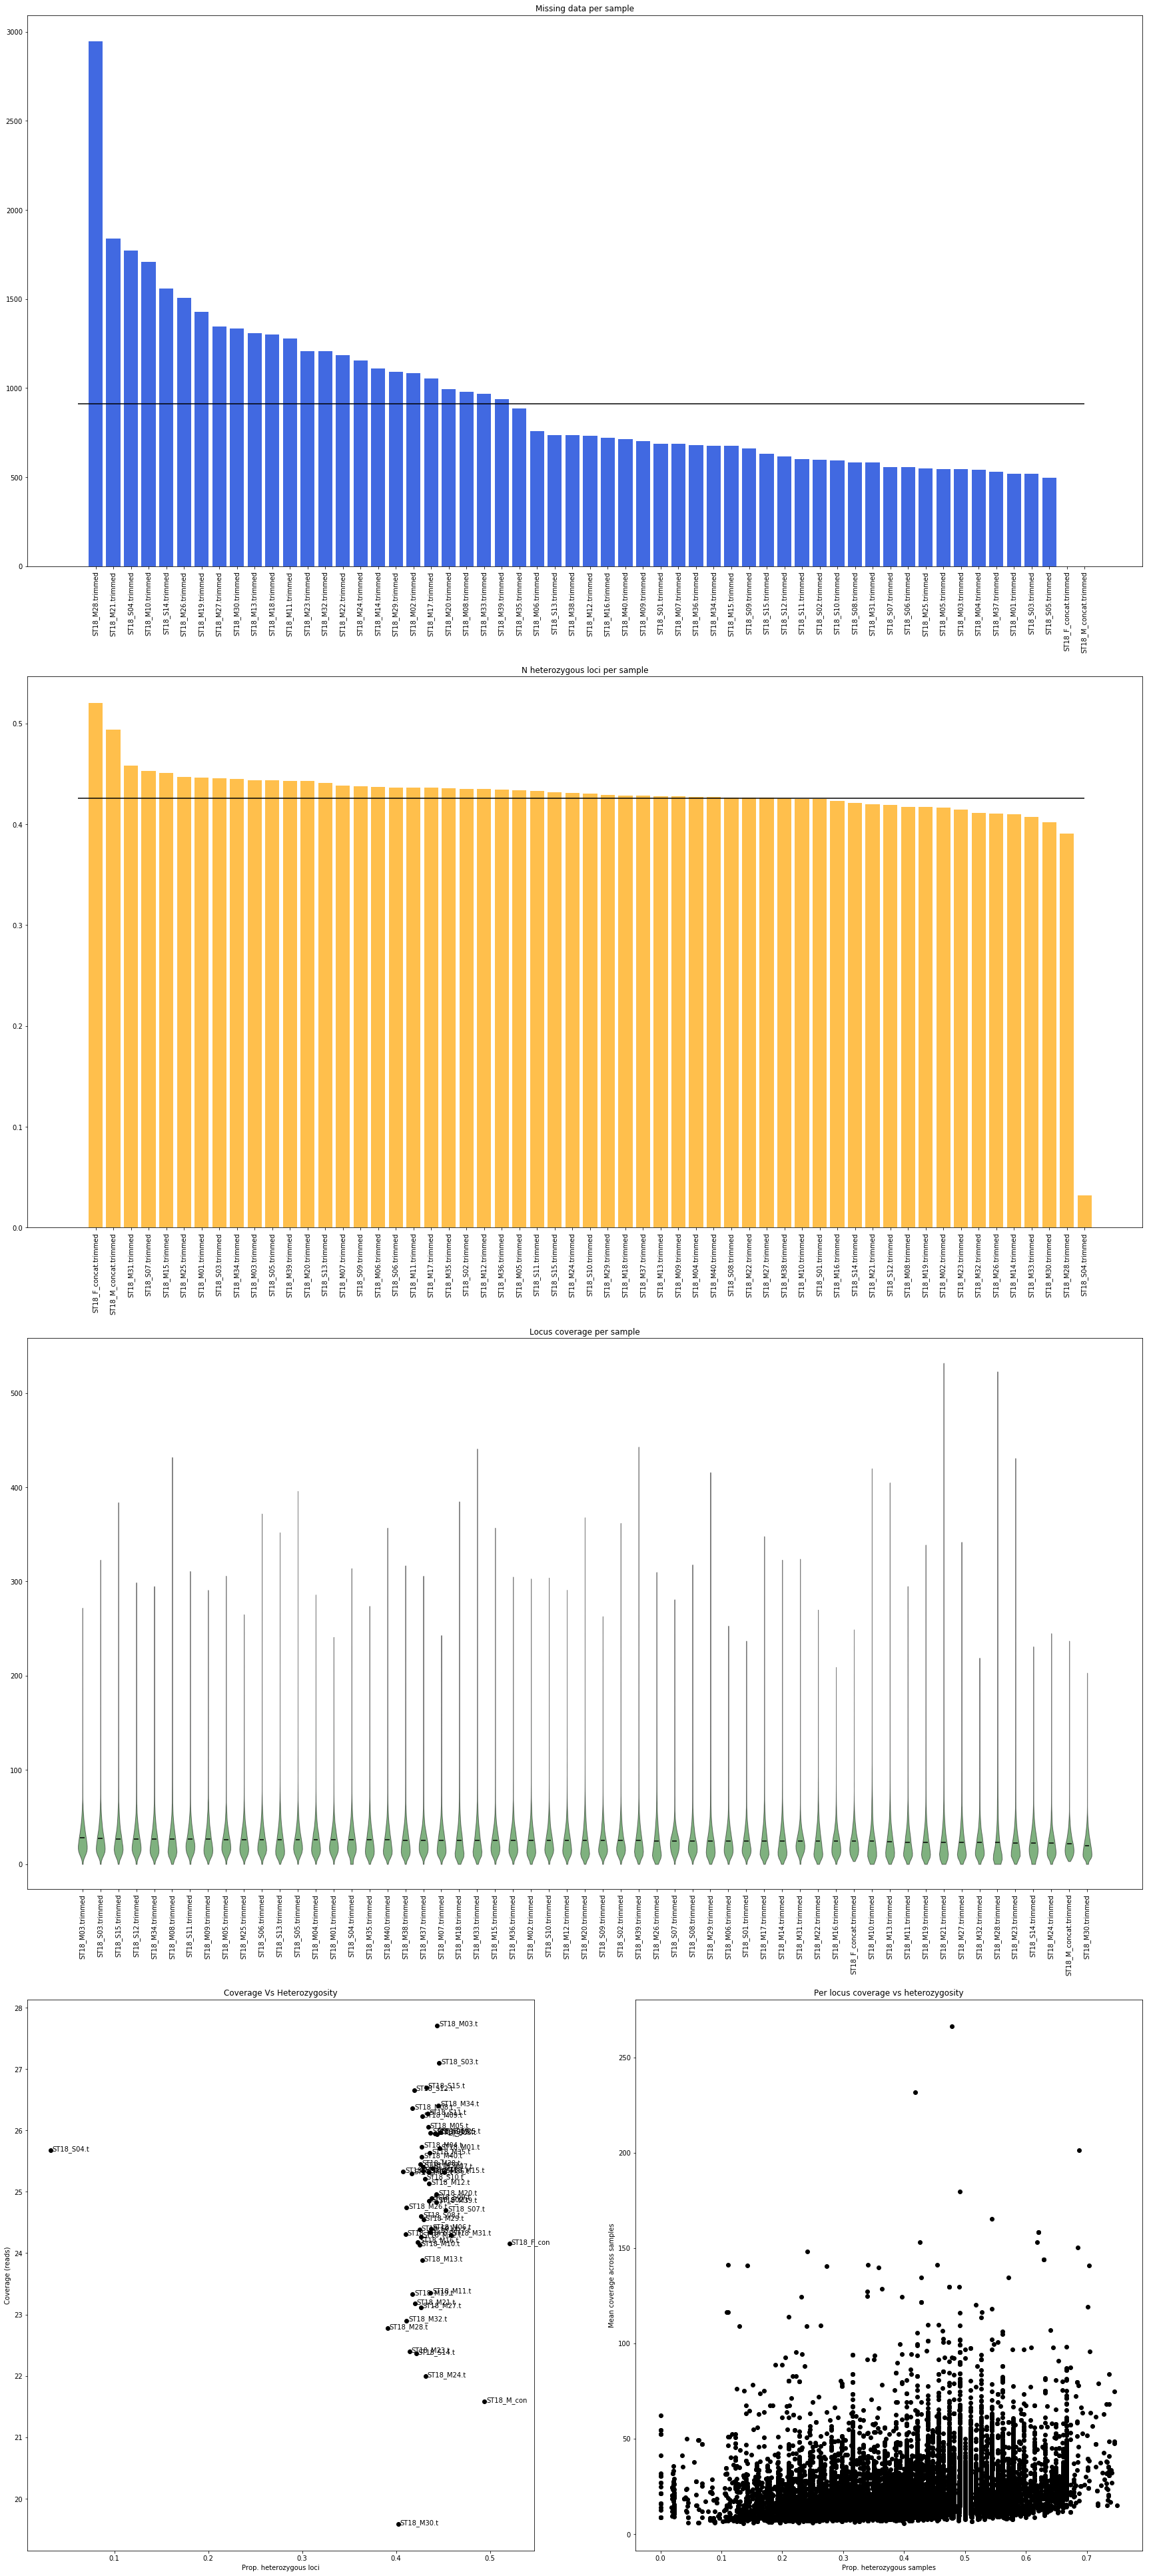

In [313]:
vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Final_linkage_map/Populations_ST18/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))

Remove: ST18_M30

### ST43

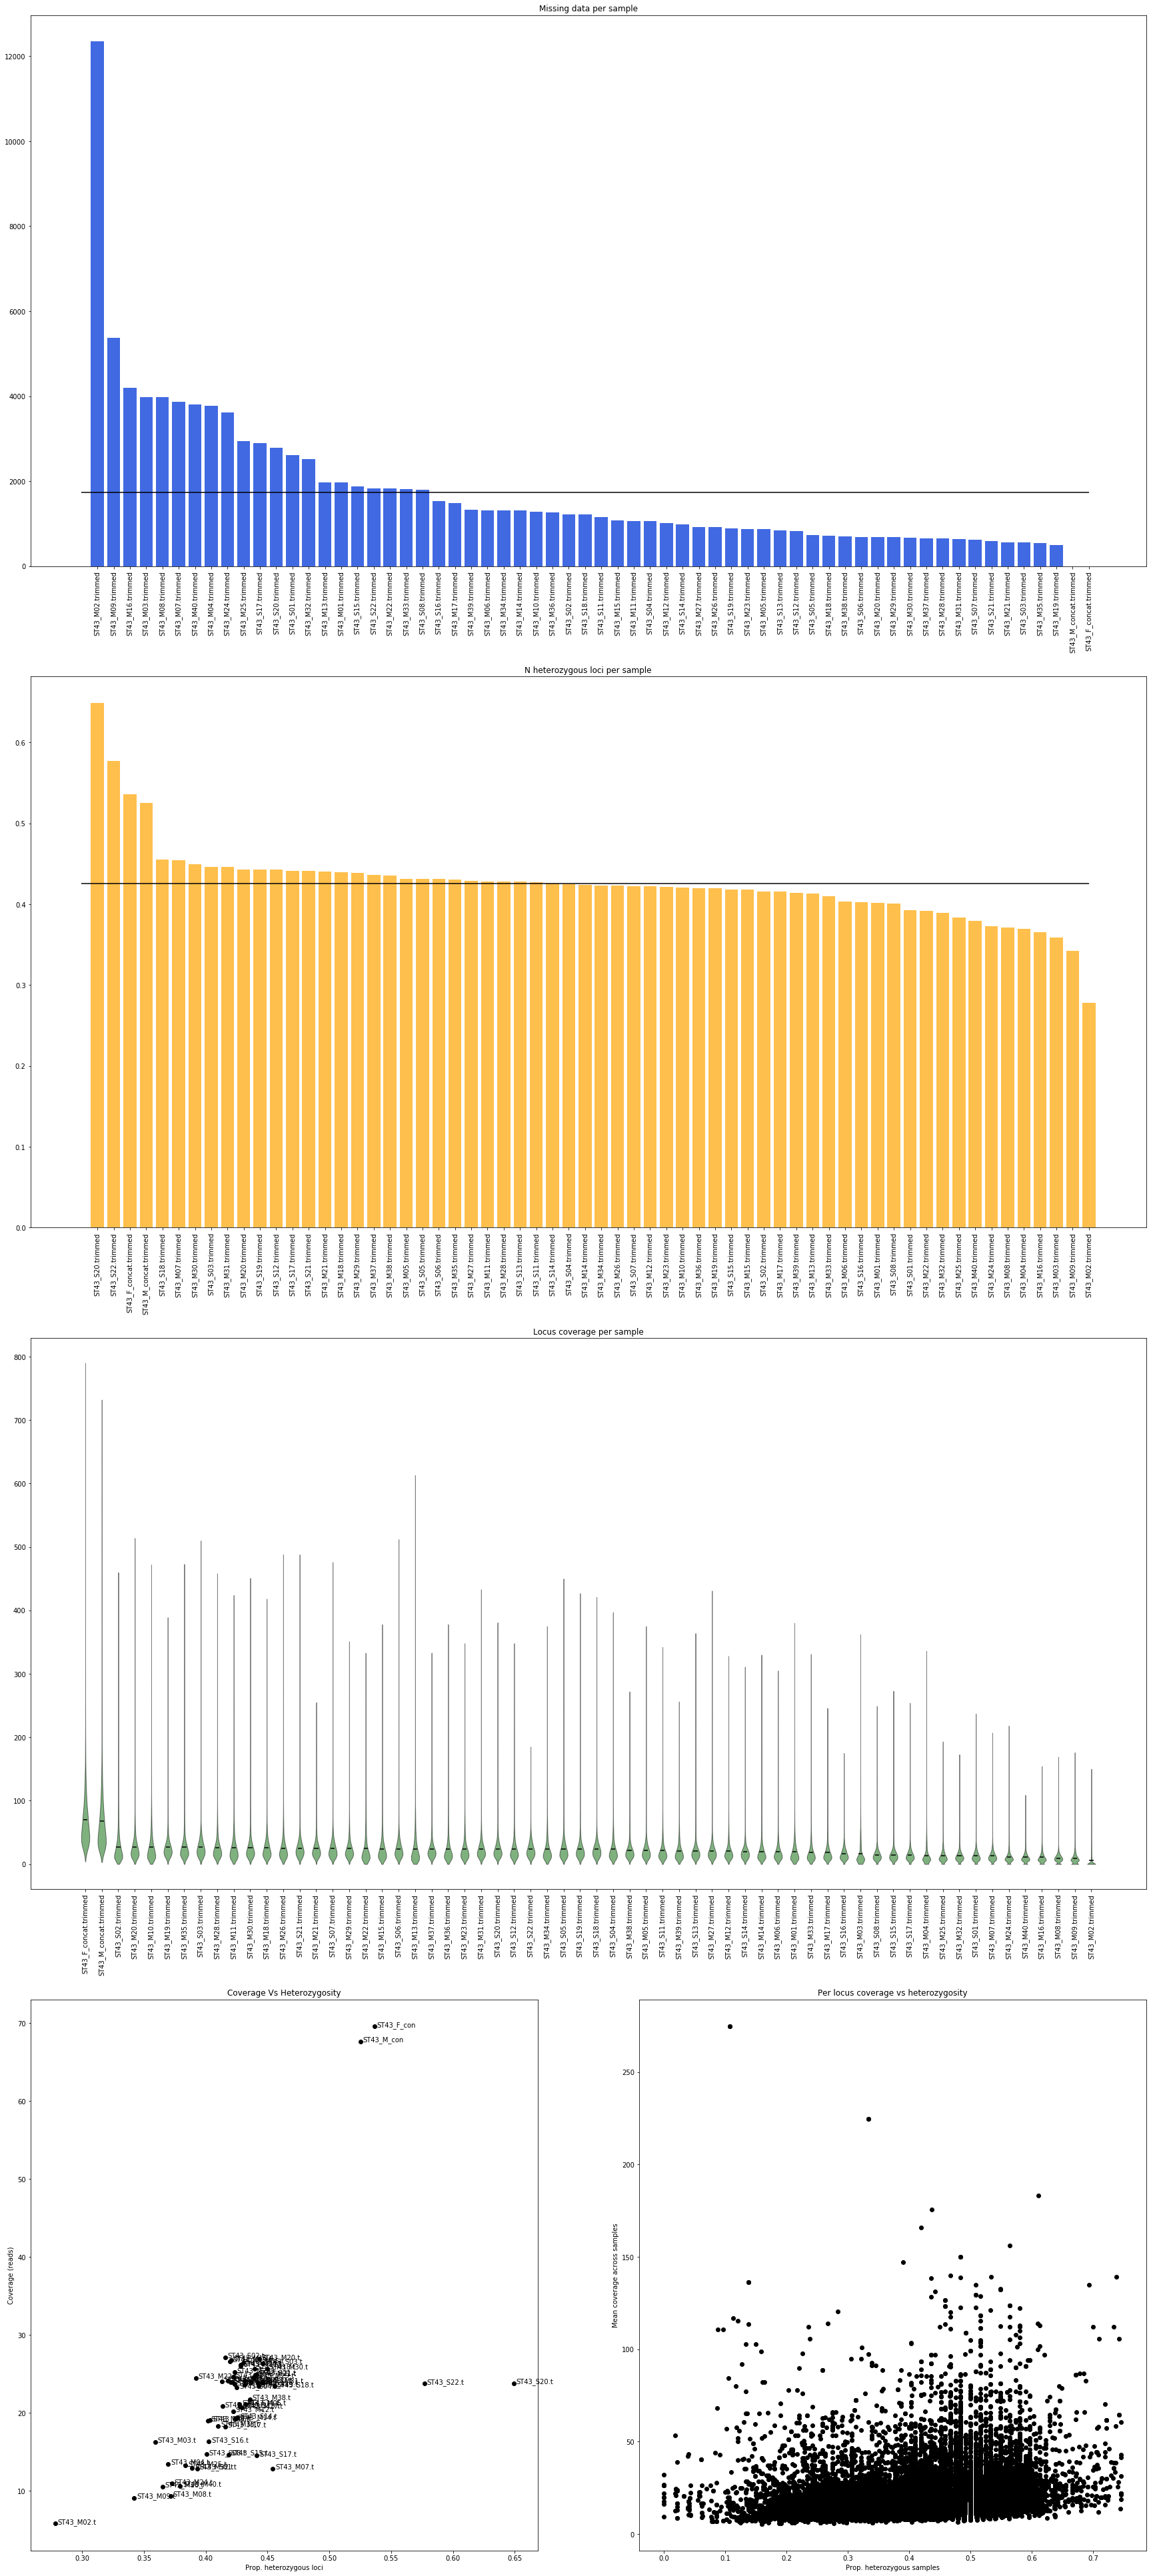

In [314]:
vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Final_linkage_map/Populations_ST43/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))

Remove: ST43_M02, ST43_M09

### ST45

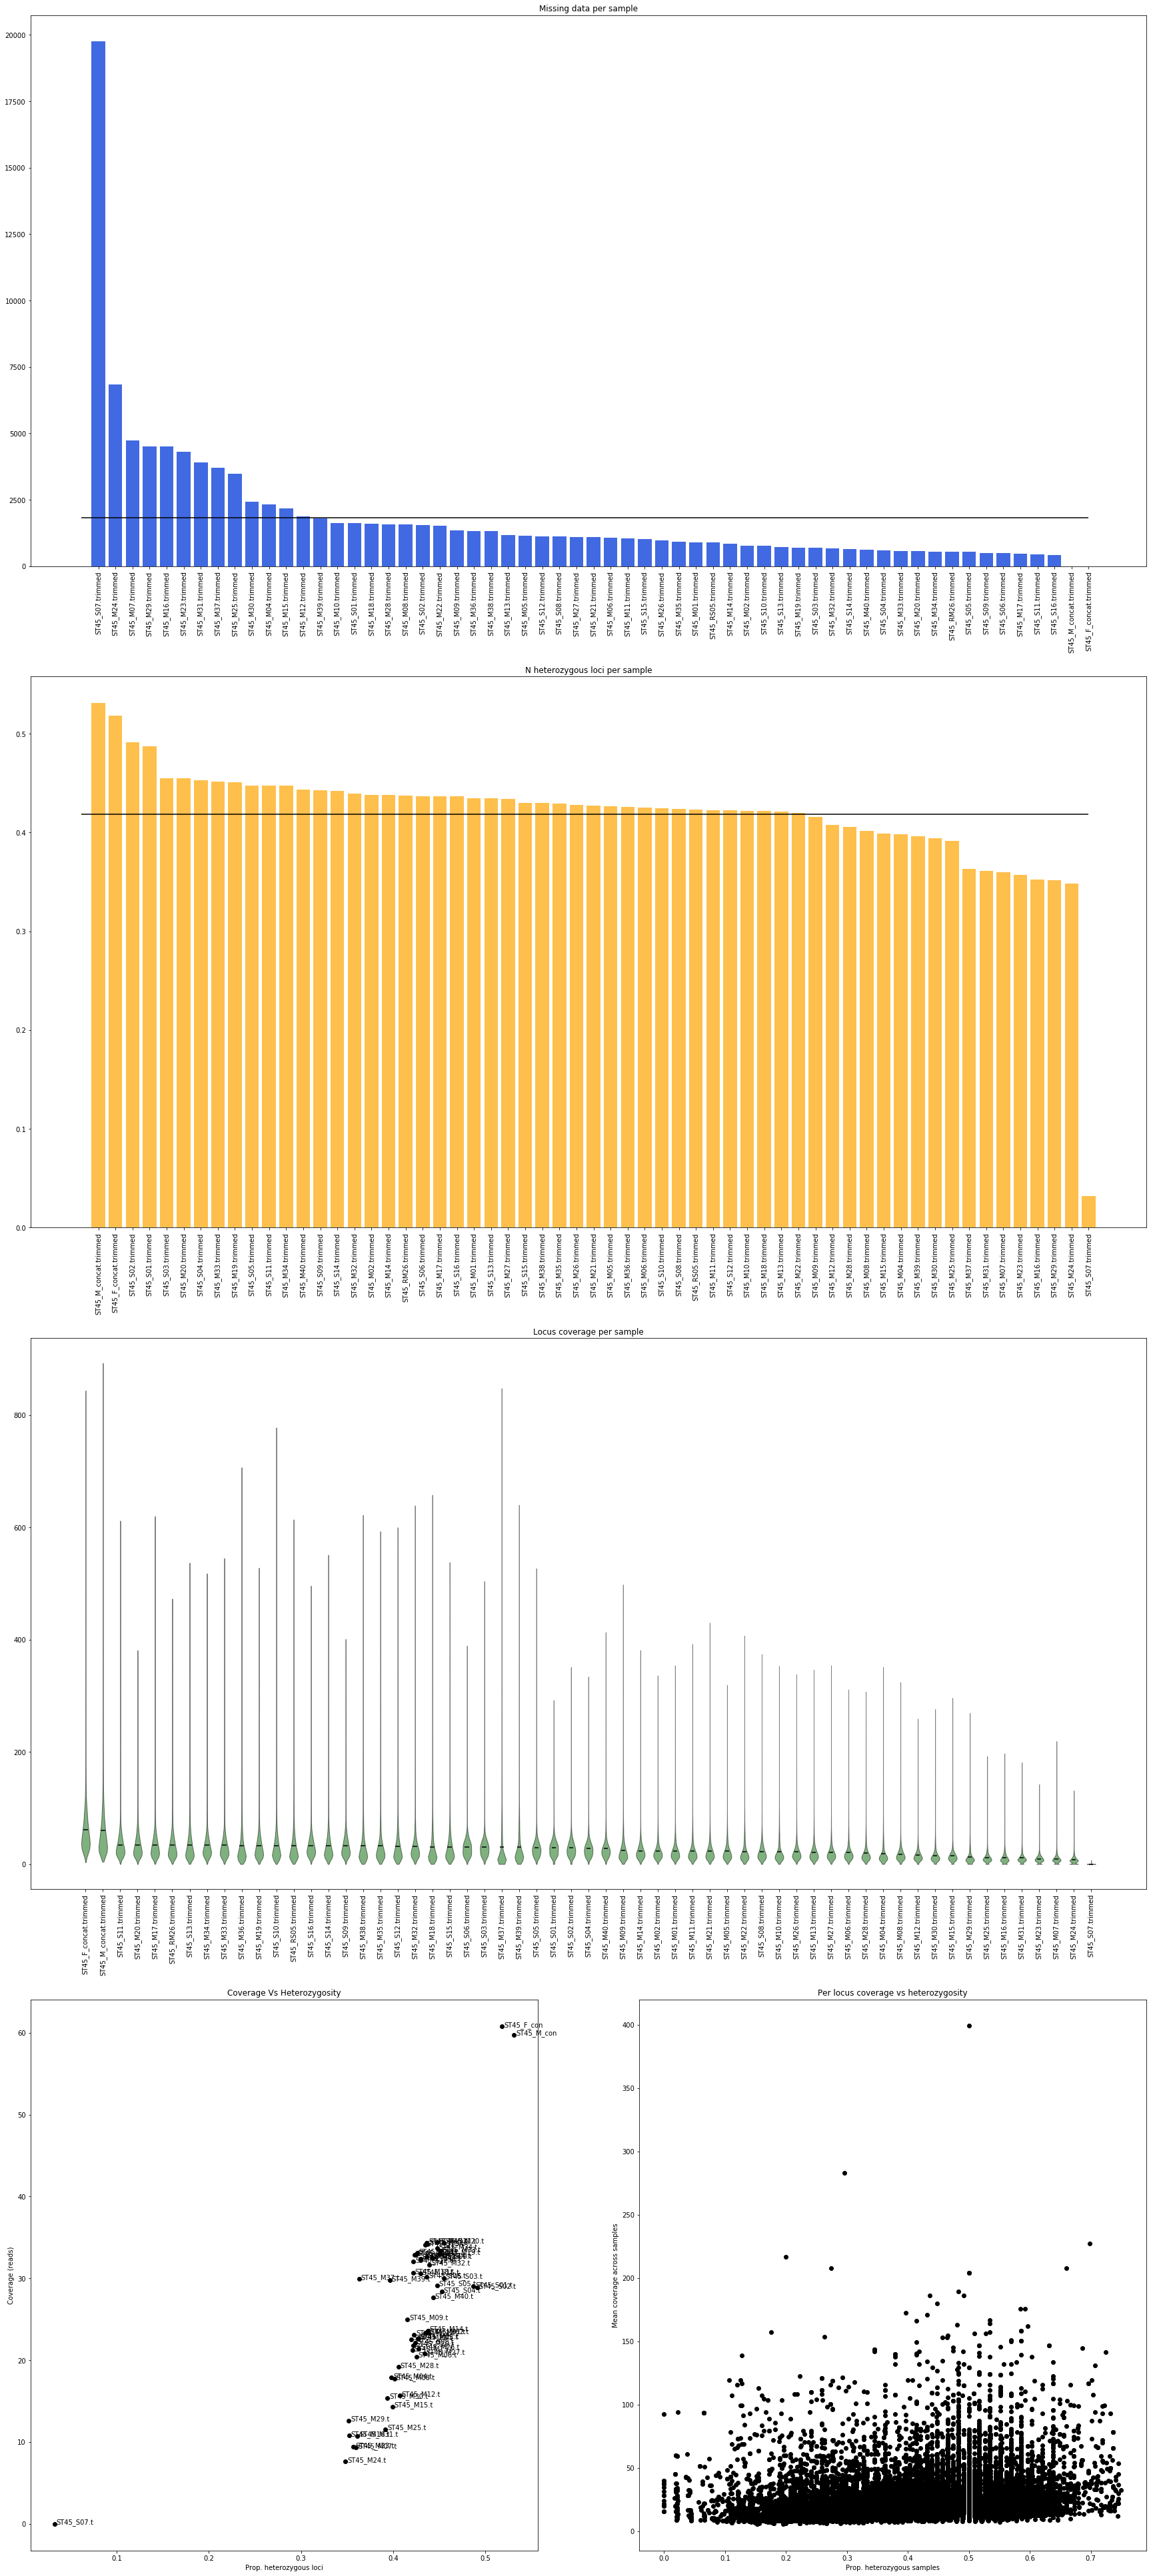

In [315]:
vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Final_linkage_map/Populations_ST45/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))

Remove: ST45_S07, ST45_M24

### ST99

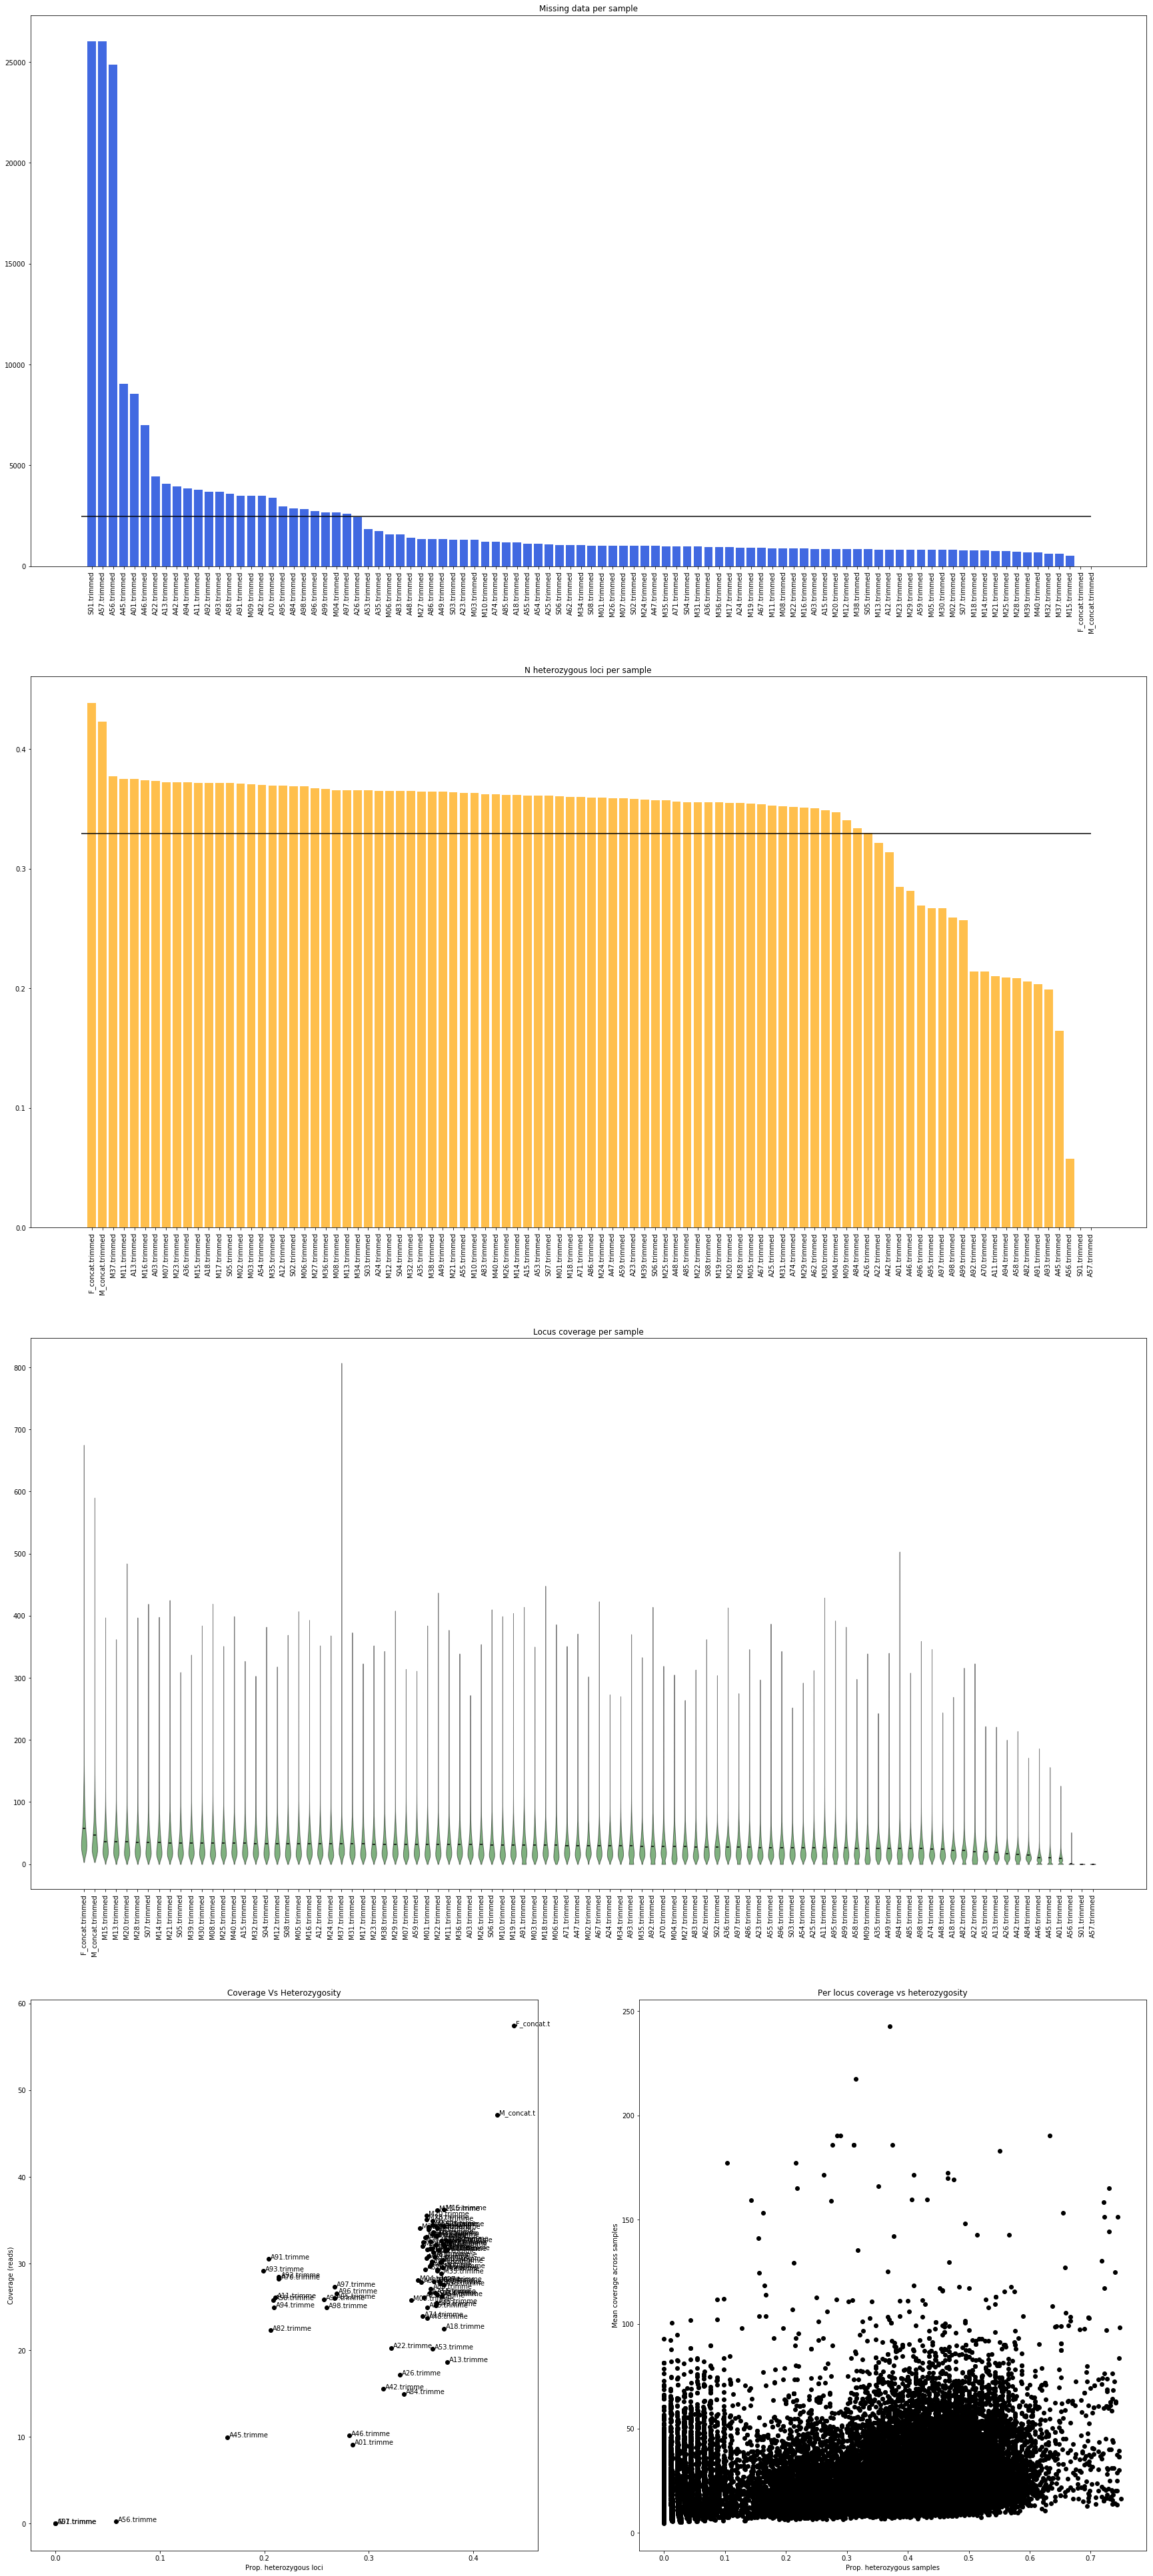

#### DONE ####

Number of Loci = 26024
Average coverage = 28.0765042795 reads


In [324]:
vcf_path = "/home/djeffrie/Data/RADseq/R_temp_fams/Final_linkage_map/Populations_ST99/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))

Remove: A57, A56, A45, A01, A46, A91, A93, A92, A70, A97, A96, A95, A99, A11, A58, A94, A98, A82, S01  

## Pooled dataset

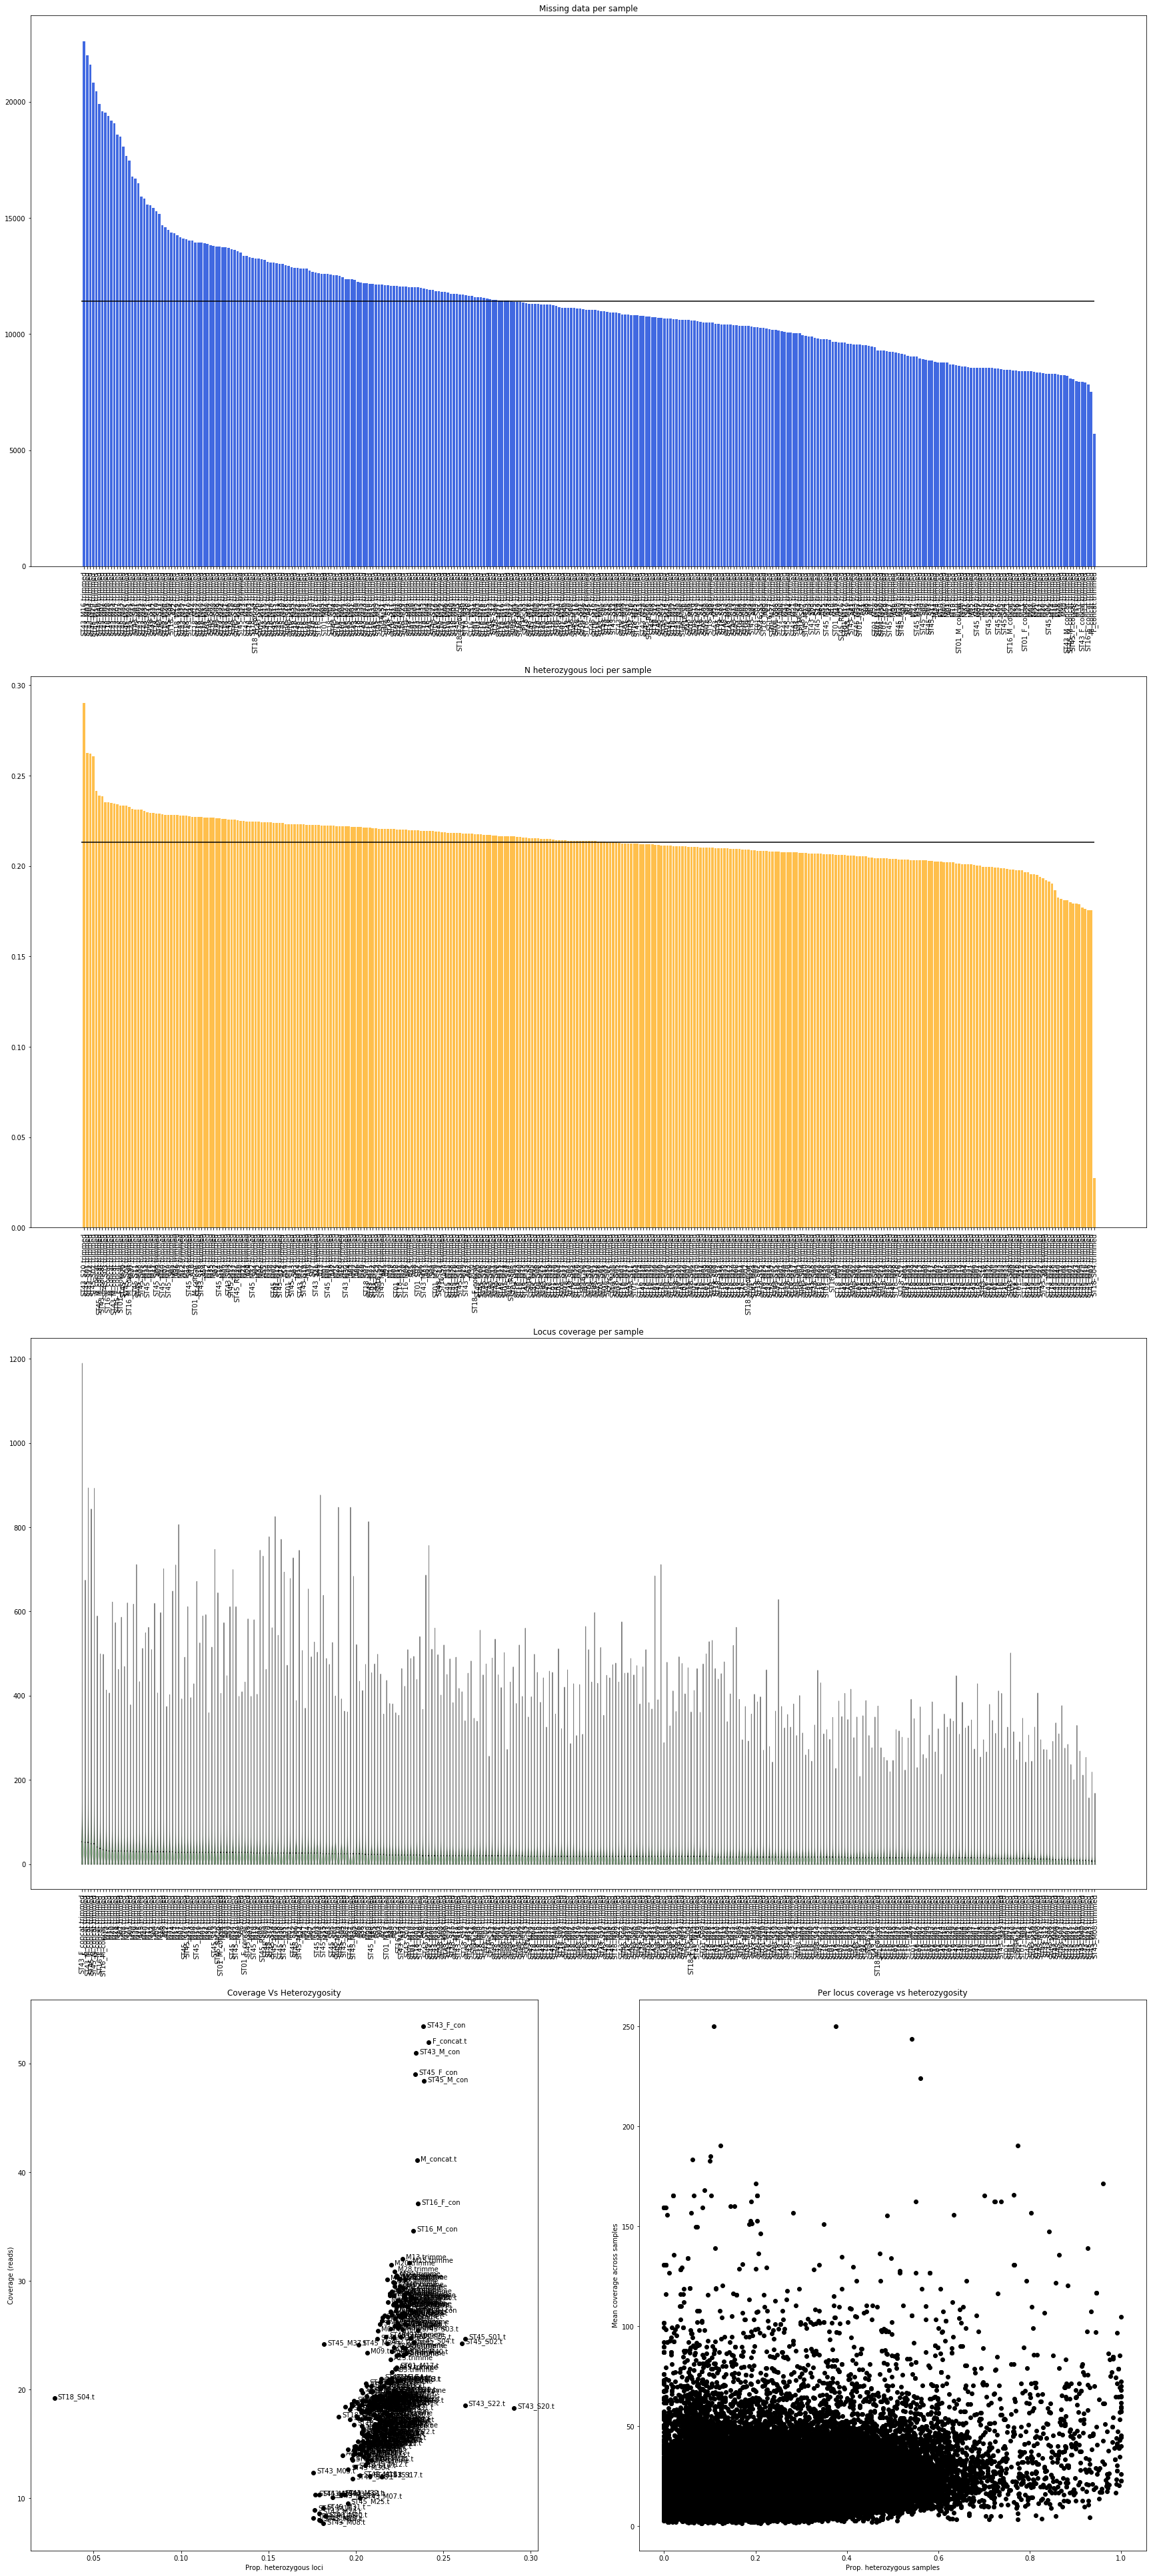

#### DONE ####

Number of Loci = 64078
Average coverage = 20.26 reads


In [4]:
vcf_path = "/home/djeffrie/Data/Genomes/Rtemp_hybrid/Rtemp_SbfI_linkage_map/VCF_2019/batch_1.vcf"

Missing_data_plotter(vcf_path, (1,1,1,1))